In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os

In [12]:
# read all dataset

stock_2008 = pd.read_csv("dataset/2008_Global_Markets_Data.csv")
stock_2009 = pd.read_csv("dataset/2009_Global_Markets_Data.csv")
stock_2010 = pd.read_csv("dataset/2010_Global_Markets_Data.csv")
stock_2011 = pd.read_csv("dataset/2011_Global_Markets_Data.csv")
stock_2012 = pd.read_csv("dataset/2012_Global_Markets_Data.csv")
stock_2013 = pd.read_csv("dataset/2013_Global_Markets_Data.csv")
stock_2014 = pd.read_csv("dataset/2014_Global_Markets_Data.csv")
stock_2015 = pd.read_csv("dataset/2015_Global_Markets_Data.csv")
stock_2016 = pd.read_csv("dataset/2016_Global_Markets_Data.csv")
stock_2017 = pd.read_csv("dataset/2018_Global_Markets_Data.csv")
stock_2018 = pd.read_csv("dataset/2018_Global_Markets_Data.csv")
stock_2019 = pd.read_csv("dataset/2019_Global_Markets_Data.csv")
stock_2020 = pd.read_csv("dataset/2020_Global_Markets_Data.csv")
stock_2021 = pd.read_csv("dataset/2021_Global_Markets_Data.csv")
stock_2022 = pd.read_csv("dataset/2022_Global_Markets_Data.csv")
stock_2023 = pd.read_csv("dataset/2023_Global_Markets_Data.csv")

stock_2010.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,^NYA,2010-01-04,7184.979980,7331.120117,7184.979980,7326.740234,7326.740234,3.991400e+09
1,^IXIC,2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1.931380e+09
2,^FTSE,2010-01-04,5412.899902,5500.299805,5410.799805,5500.299805,5500.299805,7.509420e+08
3,^NSEI,2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.000000e+00
4,^BSESN,2010-01-04,17473.449219,17582.839844,17378.380859,17558.730469,17558.730469,2.820000e+04


Epoch 1/20, Loss: 0.1653
Epoch 2/20, Loss: 0.1389
Epoch 3/20, Loss: 0.1174
Epoch 4/20, Loss: 0.1054
Epoch 5/20, Loss: 0.0799
Epoch 6/20, Loss: 0.0523
Epoch 7/20, Loss: 0.0316
Epoch 8/20, Loss: 0.0230
Epoch 9/20, Loss: 0.0280
Epoch 10/20, Loss: 0.0263
Epoch 11/20, Loss: 0.0214
Epoch 12/20, Loss: 0.0174
Epoch 13/20, Loss: 0.0178
Epoch 14/20, Loss: 0.0158
Epoch 15/20, Loss: 0.0183
Epoch 16/20, Loss: 0.0158
Epoch 17/20, Loss: 0.0159
Epoch 18/20, Loss: 0.0149
Epoch 19/20, Loss: 0.0184
Epoch 20/20, Loss: 0.0163
Next 5 days predicted prices:
Day 1: $893.68
Day 2: $895.92
Day 3: $901.85
Day 4: $886.79
Day 5: $887.19


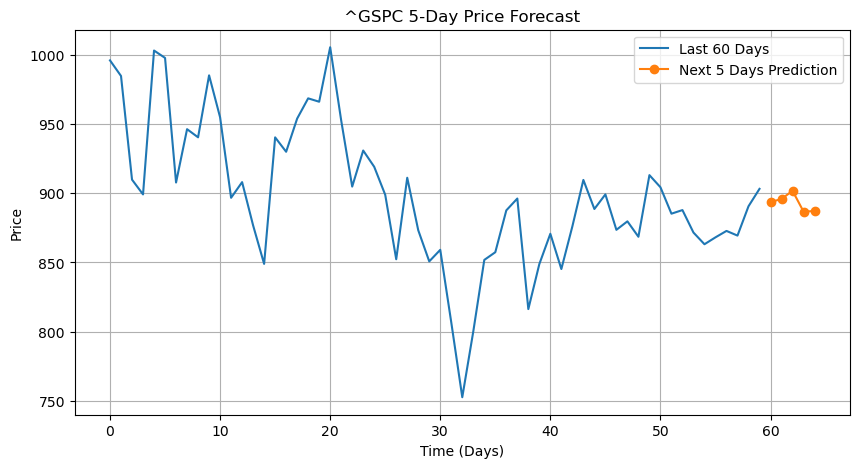

In [ ]:
# Testing model on 1 stock with option to predict 5 or 10 days

# path and load data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
stock_2008 = stock_2008[stock_2008["Ticker"] == "^GSPC"].sort_values("Date")
close_prices = stock_2008["Close"].values[-1000:].reshape(-1, 1)

# normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

# hyperparameters tuning
INPUT_WINDOW = 60
PREDICT_DAYS = 5
EPOCHS = 20
BATCH_SIZE = 32

# dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_window, pred_days):
        self.X = []
        self.y = []
        for i in range(input_window, len(data) - pred_days + 1):
            self.X.append(data[i - input_window:i])
            self.y.append(data[i:i + pred_days])
        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.FloatTensor(self.y[idx]).squeeze()

# build dataset
dataset = TimeSeriesDataset(scaled_data, INPUT_WINDOW, PREDICT_DAYS)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# LSTM model
class LSTM5DayModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=PREDICT_DAYS):
        super(LSTM5DayModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # use the output at the last time step
        out = self.fc(out)
        return out

# initialize model
model = LSTM5DayModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training model
model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")

# predict on last 60-day window
model.eval()
last_60 = torch.FloatTensor(scaled_data[-INPUT_WINDOW:]).unsqueeze(0).to(device)
with torch.no_grad():
    pred_scaled = model(last_60).cpu().numpy()

# inverse transformmation prediction
pred_prices = scaler.inverse_transform(pred_scaled.reshape(-1, 1))

# predictions
print("Next 5 days predicted prices:")
for i, price in enumerate(pred_prices.flatten(), 1):
    print(f"Day {i}: ${price:.2f}")

# plotting for result
plt.figure(figsize=(10, 5))
plt.plot(range(60), scaler.inverse_transform(scaled_data[-60:]), label="Last 60 Days")
plt.plot(range(60, 65), pred_prices, marker='o', label="Next 5 Days Prediction")
plt.title("^GSPC 5-Day Price Forecast")
plt.xlabel("Time (Days)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# load and combine all data
data_dir = "dataset"
all_years = []
for year in range(2008, 2024):
    filename = f"{year}_Global_Markets_Data.csv"
    path = os.path.join(data_dir, filename)
    df = pd.read_csv(path)
    all_years.append(df)

In [23]:
# valid ticker
valid_tickers = ["^GSPC", "^IXIC", "^FTSE", "^NSEI", "^BSESN", "^N225", "000001.SS", "^N100", "^DJI", "GC=F", "CL=F"]

In [ ]:
# combine and sort data
stock_all = pd.concat(all_years).sort_values("Date").reset_index(drop=True)
stock_all["Date"] = pd.to_datetime(stock_all["Date"])

# how many test days you want to reserve
PREDICT_DAYS = 10

# collect results
test_windows = {}

for ticker in valid_tickers:
    data = stock_all[stock_all["Ticker"] == ticker].sort_values("Date")
    
    if len(data) < 1400:
        print(f"Skipping {ticker}: Not enough data points.")
        continue

    # get the date range used in the last 1200 days
    last_1200 = data.iloc[-1200:]
    first_train_date = last_1200.iloc[0]["Date"]

    # get a backtest window before that, with some buffer
    before_training_data = data[data["Date"] < first_train_date]
    
    if len(before_training_data) < PREDICT_DAYS:
        print(f"Skipping {ticker}: Not enough data before training set for backtest.")
        continue

    test_set = before_training_data.iloc[-PREDICT_DAYS:]
    test_windows[ticker] = test_set[["Date", "Close"]].reset_index(drop=True)

# display results
for ticker, df in test_windows.items():
    print(f"\nTicker: {ticker} — Backtest Window (Before Last 1200 Days)")
    print(df)



Ticker: ^GSPC — Backtest Window (Before Last 1200 Days)
        Date        Close
0 2018-10-05  2885.570068
1 2018-10-08  2884.429932
2 2018-10-09  2880.340088
3 2018-10-10  2785.679932
4 2018-10-11  2728.370117
5 2018-10-12  2767.129883
6 2018-10-15  2750.790039
7 2018-10-16  2809.919922
8 2018-10-17  2809.209961
9 2018-10-18  2768.780029

Ticker: ^IXIC — Backtest Window (Before Last 1200 Days)
        Date        Close
0 2018-10-05  7788.450195
1 2018-10-08  7735.950195
2 2018-10-09  7738.020020
3 2018-10-10  7422.049805
4 2018-10-11  7329.060059
5 2018-10-12  7496.890137
6 2018-10-15  7430.740234
7 2018-10-16  7645.490234
8 2018-10-17  7642.700195
9 2018-10-18  7485.140137

Ticker: ^FTSE — Backtest Window (Before Last 1200 Days)
        Date        Close
0 2018-10-10  7145.700195
1 2018-10-11  7006.899902
2 2018-10-12  6995.899902
3 2018-10-15  7029.200195
4 2018-10-16  7059.399902
5 2018-10-17  7054.600098
6 2018-10-18  7027.000000
7 2018-10-19  7049.799805
8 2018-10-22  7042.7998

In [24]:
# 2009 dataset train and test

# config
test_days = 15
base_output_dir = "test_dataset"
test_output_dir = os.path.join(base_output_dir, "test")
train_output_dir = os.path.join(base_output_dir, "train")

# ensure output folders exist
os.makedirs(test_output_dir, exist_ok=True)
os.makedirs(train_output_dir, exist_ok=True)

stock_2009["Date"] = pd.to_datetime(stock_2009["Date"])

# process each ticker
for ticker in valid_tickers:
    df_ticker = stock_2009[stock_2009["Ticker"] == ticker].sort_values("Date").reset_index(drop=True)

    if len(df_ticker) < test_days + 60:
        print(f"Skipping {ticker}: not enough 2009 data ({len(df_ticker)} rows).")
        continue

    # split train and test
    test_df = df_ticker.iloc[-test_days:].reset_index(drop=True)
    train_df = df_ticker.iloc[:-test_days].reset_index(drop=True)

    # safe filename
    safe_name = ticker.replace("/", "_").replace("=", "")

    # file path for to_csv
    test_csv = os.path.join(test_output_dir, f"{safe_name}.csv")
    train_csv = os.path.join(train_output_dir, f"{safe_name}.csv")

    # save train and test to new csv
    test_df.to_csv(test_csv, index=False)
    train_df.to_csv(train_csv, index=False)

    print(f"{ticker}: train ➜ {train_csv}, test ➜ {test_csv}")


^GSPC: train ➜ test_dataset\train\^GSPC.csv, test ➜ test_dataset\test\^GSPC.csv
^IXIC: train ➜ test_dataset\train\^IXIC.csv, test ➜ test_dataset\test\^IXIC.csv
^FTSE: train ➜ test_dataset\train\^FTSE.csv, test ➜ test_dataset\test\^FTSE.csv
^NSEI: train ➜ test_dataset\train\^NSEI.csv, test ➜ test_dataset\test\^NSEI.csv
^BSESN: train ➜ test_dataset\train\^BSESN.csv, test ➜ test_dataset\test\^BSESN.csv
^N225: train ➜ test_dataset\train\^N225.csv, test ➜ test_dataset\test\^N225.csv
000001.SS: train ➜ test_dataset\train\000001.SS.csv, test ➜ test_dataset\test\000001.SS.csv
^N100: train ➜ test_dataset\train\^N100.csv, test ➜ test_dataset\test\^N100.csv
^DJI: train ➜ test_dataset\train\^DJI.csv, test ➜ test_dataset\test\^DJI.csv
GC=F: train ➜ test_dataset\train\GCF.csv, test ➜ test_dataset\test\GCF.csv
CL=F: train ➜ test_dataset\train\CLF.csv, test ➜ test_dataset\test\CLF.csv


In [25]:
# 2010 dataset train and test

# config
test_days = 15
base_output_dir = "test_dataset_2"
test_output_dir = os.path.join(base_output_dir, "test")
train_output_dir = os.path.join(base_output_dir, "train")

# ensure output folders exist
os.makedirs(test_output_dir, exist_ok=True)
os.makedirs(train_output_dir, exist_ok=True)

# load 2009 only
stock_2010["Date"] = pd.to_datetime(stock_2010["Date"])

# process each ticker
for ticker in valid_tickers:
    df_ticker = stock_2010[stock_2010["Ticker"] == ticker].sort_values("Date").reset_index(drop=True)

    if len(df_ticker) < test_days + 60:
        print(f"Skipping {ticker}: not enough 2009 data ({len(df_ticker)} rows).")
        continue

    # split
    test_df = df_ticker.iloc[-test_days:].reset_index(drop=True)
    train_df = df_ticker.iloc[:-test_days].reset_index(drop=True)

    # safe filename
    safe_name = ticker.replace("/", "_").replace("=", "")

    # file paths
    test_csv = os.path.join(test_output_dir, f"{safe_name}.csv")
    train_csv = os.path.join(train_output_dir, f"{safe_name}.csv")

    # save files
    test_df.to_csv(test_csv, index=False)
    train_df.to_csv(train_csv, index=False)

    print(f"{ticker}: train ➜ {train_csv}, test ➜ {test_csv}")


^GSPC: train ➜ test_dataset_2\train\^GSPC.csv, test ➜ test_dataset_2\test\^GSPC.csv
^IXIC: train ➜ test_dataset_2\train\^IXIC.csv, test ➜ test_dataset_2\test\^IXIC.csv
^FTSE: train ➜ test_dataset_2\train\^FTSE.csv, test ➜ test_dataset_2\test\^FTSE.csv
^NSEI: train ➜ test_dataset_2\train\^NSEI.csv, test ➜ test_dataset_2\test\^NSEI.csv
^BSESN: train ➜ test_dataset_2\train\^BSESN.csv, test ➜ test_dataset_2\test\^BSESN.csv
^N225: train ➜ test_dataset_2\train\^N225.csv, test ➜ test_dataset_2\test\^N225.csv
000001.SS: train ➜ test_dataset_2\train\000001.SS.csv, test ➜ test_dataset_2\test\000001.SS.csv
^N100: train ➜ test_dataset_2\train\^N100.csv, test ➜ test_dataset_2\test\^N100.csv
^DJI: train ➜ test_dataset_2\train\^DJI.csv, test ➜ test_dataset_2\test\^DJI.csv
GC=F: train ➜ test_dataset_2\train\GCF.csv, test ➜ test_dataset_2\test\GCF.csv
CL=F: train ➜ test_dataset_2\train\CLF.csv, test ➜ test_dataset_2\test\CLF.csv
